# **College Student Placement Factors Dataset** #

#### Credits to `SAHIL ISLAM007` for the dataset. ####

Source: https://www.kaggle.com/datasets/sahilislam007/college-student-placement-factors-dataset?resource=download


## Libraries ##

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore, pearsonr
from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from factor_analyzer.factor_analyzer import calculate_kmo, FactorAnalyzer

## Dataset ##

In [ ]:
path = r'Insert data path here'
data = pd.read_csv(path)

In [3]:
print(data.info())

#print(data.describe())

#print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   College_ID              10000 non-null  object 
 1   IQ                      10000 non-null  int64  
 2   Prev_Sem_Result         10000 non-null  float64
 3   CGPA                    10000 non-null  float64
 4   Academic_Performance    10000 non-null  int64  
 5   Internship_Experience   10000 non-null  object 
 6   Extra_Curricular_Score  10000 non-null  int64  
 7   Communication_Skills    10000 non-null  int64  
 8   Projects_Completed      10000 non-null  int64  
 9   Placement               10000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 781.4+ KB
None


### Known Fields ###
- **College_ID**
    - Unique ID of colleges.
- **IQ**
    - Student IQ score (normally distributed around 100.)
- **Prev_Sem_Result**
    -  Grade point average of previous semester (range of 5.0 to 10.0).
- **CGPA**
    - Cumulative Grde Point Average  (range of ~5.0 to 10.0)
- **Academic_Performance**
    - Scale (1 to 10) for annual academic rating.
- **Internship_Experience**
    - Boolean ('Yes'/'No') for student past internship experience.
- **Communication_Skills**
    - Scale (1 to 10) for communication ability rating.
- **Projects_Completed**
    - Count (0 to 5) of projects completed.
- **Placement**
    - Boolean ('Yes'/'No') of whether student got a placement.

## Objectives (Current) ##
- Clean/normalize/adjust dataset for data analysis if needed.
- Identify preliminary (linear) relationships between data using a correlation matrix with p-values for significance.
- Identify key factors and their importance that influence placement using factor analysis (or other) methods.
- Consider feature engineer a ``Student_Score`` using factors (and weightings if needed) for determining placement.
- Test ``Student_Score`` for suitability using a decision tree.
- If suitable, identify key thresholds that can be used for automating placement decisions using ``Student_Score``. Consider methods such as logistic regression or random forest.
- Train a model to categorise whether a student will get a placement or not. Consider ensemble learning methods for improved accuracy.
- Test the model for suitability.

## Cleaning Dataset ##

In [4]:
empty_columns = data.columns[data.isnull().any()].to_list()
print("Columns with empty values: ", empty_columns)

Columns with empty values:  []


In [5]:
dupes = data[data.duplicated()]
print("Duplicate values: ", dupes.shape[0])

Duplicate values:  0


#### Outlier Detection w/ z-Score ####
Outliers should only be possible in quantitative fields.

In [6]:
 #Possible fields: 'IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Projects_Completed'

#Parameters
outlier_std = 3         #Default is 3.
quantitative_fields = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Projects_Completed']


#### Note: ####
Function `find_outliers` will re-define z-scores when called. <br>
Therefore updating the dataset AND calling the function after, can cause new outliers to re-emerge based on updated dataset.

In [7]:
#Return relevant outlier values.
def find_outliers(param_field):
    data_z = pd.DataFrame(zscore(data[param_field], nan_policy='omit'), columns=[param_field], index=data.index)
    outlier_mask = (abs(data_z) > outlier_std).any(axis=1)
    outliers = data[outlier_mask]
    
    return outlier_mask, outliers
    
mask, outliers = find_outliers(quantitative_fields)

print(outliers)

     College_ID   IQ  Prev_Sem_Result  CGPA  Academic_Performance  \
209     CLG0073  157             8.33  8.53                     4   
262     CLG0004   51             7.26  7.43                     1   
478     CLG0047  146             9.72  9.44                     8   
1615    CLG0037  147             8.34  7.90                     6   
1957    CLG0037  147             7.58  7.14                     4   
2024    CLG0044   54             9.04  8.82                     4   
2305    CLG0047  146             5.81  5.37                     8   
2895    CLG0056  158             6.07  5.89                     8   
3716    CLG0033  148             9.37  9.08                     1   
3982    CLG0037  147             5.15  5.32                     9   
4198    CLG0071   54             9.07  9.27                     7   
4725    CLG0017   52             8.92  9.36                     8   
4779    CLG0057   52             7.56  7.36                     9   
4870    CLG0100  146             9

In [8]:
#Determine which columns have outliers above the specified standard deviation, and how many.
for field in quantitative_fields:
    _ , outliers = find_outliers(field)
    print(f"Number of outliers in {field}: {outliers.shape[0]}")

Number of outliers in IQ: 28
Number of outliers in Prev_Sem_Result: 0
Number of outliers in CGPA: 0
Number of outliers in Academic_Performance: 0
Number of outliers in Communication_Skills: 0
Number of outliers in Projects_Completed: 0


#### Replace Outliers ####

In [9]:
IQ_median = data['IQ'].median()
print("Median of IQ: ", IQ_median, '\n')

IQ_outlier_mask, _ = find_outliers(['IQ'])
IQ_outlier_indices = data[IQ_outlier_mask].index.tolist()

#Replace outliers of IQ values with median.
data.loc[IQ_outlier_mask, 'IQ'] = IQ_median

#Check that the outlier values have been replaced with median (99 in this case), using indexes from mask.
print("Replaced values:\n", data.loc[IQ_outlier_indices, 'IQ'])


Median of IQ:  99.0 

Replaced values:
 209     99
262     99
478     99
1615    99
1957    99
2024    99
2305    99
2895    99
3716    99
3982    99
4198    99
4725    99
4779    99
4870    99
4997    99
5796    99
6891    99
7140    99
7223    99
7305    99
7611    99
7677    99
8024    99
8180    99
8200    99
8248    99
8726    99
9770    99
Name: IQ, dtype: int64


#### Convert Boolean to Binary ####
Cast Yes/No values to 1/0. <br>
Initial data type is object so it needs to be cast into a string.

In [10]:
data['Internship_Experience'] = data['Internship_Experience'].astype(str)
data['Placement'] = data['Placement'].astype(str)

data['Internship_Experience'] = data['Internship_Experience'].map({'No' : 0, 'Yes' : 1})
data['Placement'] = data['Placement'].map({'No' : 0, 'Yes' : 1})

#print(data['Internship_Experience'])
#print(data['Placement'])

## Correlation Matrix ##
Checking linear relationships between numerical data.

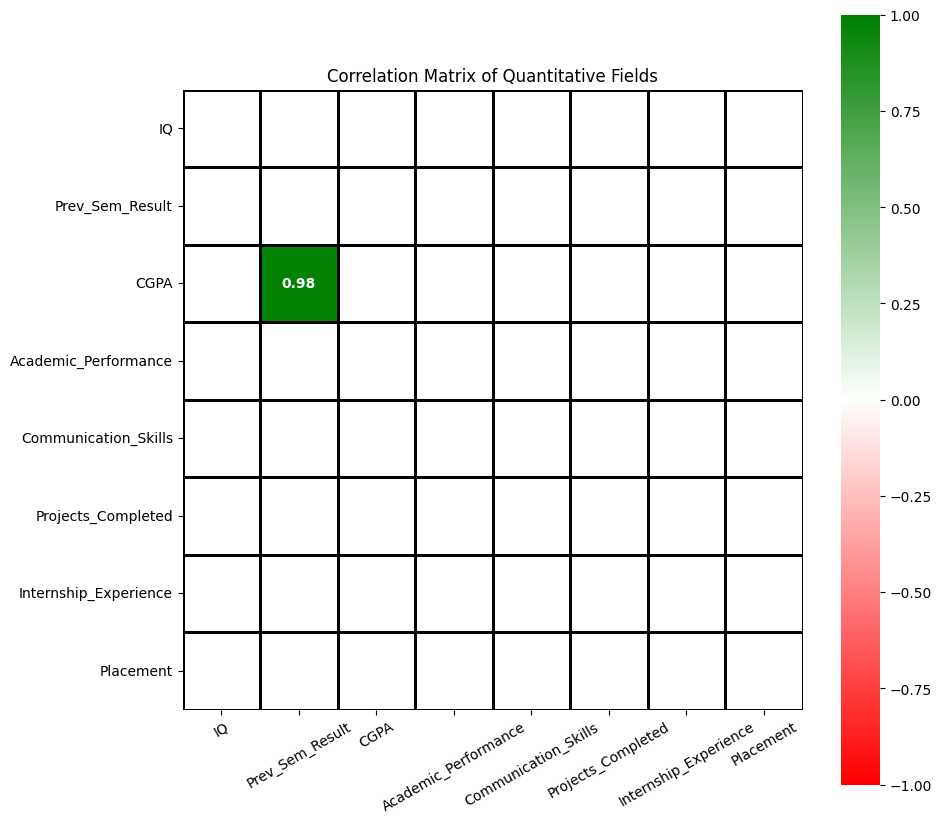

In [ ]:
#Base parameters
quantitative_fields = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Projects_Completed', 'Internship_Experience', 'Placement'] #Append new binary values.
corr_data = data[quantitative_fields].corr()
p_value_corr = round(corr_data.corr(method=lambda x, y : pearsonr(x, y)[1]), 4)
p_value = 0.05 #Default p-value for significance = 0.05

#Figure parameters
mask = np.triu(corr_data)
p_mask = np.invert(np.tril(p_value_corr < p_value))
gradient = LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
x, fig = plt.subplots(figsize=(10,10))

#Switch mask between p_value filtering depending on preference.
sns.heatmap(corr_data, mask=p_mask, cmap=gradient, vmin=-1, vmax=1, linewidths=2, linecolor='black', annot=True, annot_kws={'fontweight' : 'bold'}, square=True)
plt.title('Correlation Matrix of Quantitative Fields')
plt.xticks(rotation=30)
plt.show()